In [189]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [190]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [191]:
NUM_CLASSES = 26

# Dataset reading

In [192]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [193]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [195]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [196]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Bat  (None, 42)                168       
 chNormalization)                                                
                                                                 
 dense_36 (Dense)            (None, 128)               5504      
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                     

In [197]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [198]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [199]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
188/212 [=========================>....] - ETA: 0s - loss: 4.2553 - accuracy: 0.2071
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
212/212 [==============================] - 1s 2ms/step - loss: 4.1654 - accuracy: 0.2175 - val_loss: 3.3566 - val_accuracy: 0.3372
Epoch 2/1000
188/212 [=========================>....] - ETA: 0s - loss: 3.0468 - accuracy: 0.3262
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
212/212 [==============================] - 0s 2ms/step - loss: 3.0197 - accuracy: 0.3257 - val_loss: 2.5813 - val_accuracy: 0.4178
Epoch 3/1000
196/212 [==========================>...] - ETA: 0s - loss: 2.5791 - accuracy: 0.3750
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
212/212 [==============================] - 0s 2ms/step - loss: 2.5738 - accuracy: 0.3757 - val_loss: 2.2492 - val_accuracy: 0.4559
Epoch 4/1000
203/212 [===========================>..] - ETA: 0s - loss: 2.3714 - a

In [200]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

71/71 [==============================] - 0s 1ms/step - loss: 0.8315 - accuracy: 0.8386


In [201]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [202]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 61ms/step
[7.0640929e-03 1.5172329e-04 1.0708986e-05 7.5150318e-05 8.1622282e-05
 9.0818699e-05 9.5978302e-01 5.0274506e-03 7.5315511e-06 2.2164565e-03
 1.3996318e-02 1.0509539e-05 1.0121407e-04 7.7858795e-06 7.7255788e-07
 6.2256516e-04 1.0048895e-02 1.1321438e-04 1.0724745e-05 5.9075242e-06
 2.6169393e-04 2.6541087e-05 4.9717008e-05 7.5715303e-07 2.1657525e-04
 1.8137669e-05]
6


# Confusion matrix

282/282 [==============================] - 0s 833us/step


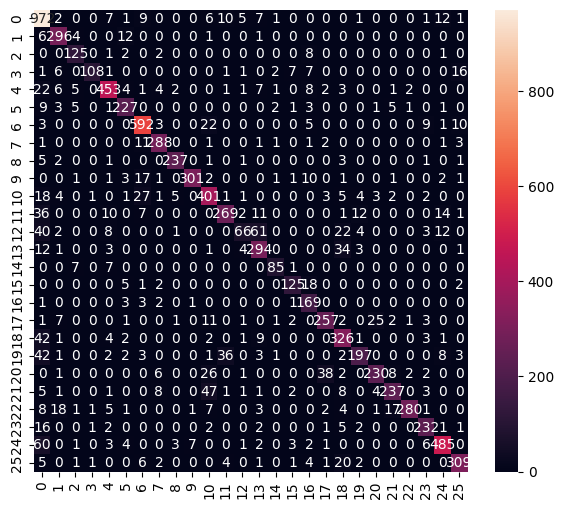

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1035
           1       0.84      0.93      0.88       320
           2       0.83      0.90      0.87       139
           3       0.96      0.72      0.82       150
           4       0.89      0.87      0.88       523
           5       0.85      0.88      0.86       259
           6       0.87      0.92      0.90       645
           7       0.90      0.93      0.92       310
           8       0.95      0.94      0.95       252
           9       0.97      0.88      0.92       343
          10       0.76      0.84      0.79       479
          11       0.83      0.74      0.78       363
          12       0.77      0.30      0.43       219
          13       0.73      0.83      0.78       353
          14       0.89      0.85      0.87       100
          15       0.87      0.82      0.84       153
          16       0.72      0.94      0.81       180
     

In [203]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [204]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [205]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\asusg\AppData\Local\Temp\tmpf20slghp\assets


INFO:tensorflow:Assets written to: C:\Users\asusg\AppData\Local\Temp\tmpf20slghp\assets


23288

# Inference test

In [206]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [207]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [208]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [209]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [210]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.7461808e-03 1.3303166e-04 9.6226686e-06 7.1089067e-05 7.3165364e-05
 8.0808473e-05 9.6141154e-01 4.8557781e-03 7.4218360e-06 2.2252304e-03
 1.3419672e-02 9.9238550e-06 9.2161179e-05 7.2694265e-06 7.0603357e-07
 5.9611397e-04 9.5982114e-03 1.0611208e-04 1.0198273e-05 5.6111448e-06
 2.4085527e-04 2.4901143e-05 4.4219298e-05 7.4703394e-07 2.1118812e-04
 1.8260283e-05]
6
